In [1]:
%load_ext autoreload
%autoreload 2

# Simulation settings

In [2]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB

L_arr = [8, 16, 24, 32, 40, 48, 50]
J = 1
h = 0.05
lamb = 0.7
g = None

x_basis = False

particle_pair_left_positions = [L//2 - 1 for L in L_arr]
particle_pair_length = 1

final_time = 8
steps = 35

shots = [10000]
optimization_levels = [0]
zne_extrapolator_levels = [("linear", [1, 1.2, 1.5])] #[None, ("linear", [1, 1.2, 1.5]), ("linear", [1, 2, 3]), ("linear", [1, 3, 5])]
measure_mitigations = [True]
dd_sequences = ["XY4"]
twirlings = [True]

execution_database = "z2_chain_jobs.json"
job_db = ExecDB(execution_database)

estimator_options_dict = create_estimator_options(shots, optimization_levels, zne_extrapolator_levels, measure_mitigations, dd_sequences, twirlings)
extra_options = [{"L": L, "J": J, "h": h, "λ":lamb, "g": g, "particle_pair_position": pp_pos, "particle_pair_length": particle_pair_length, "final_time": final_time} for L, pp_pos in zip(L_arr, particle_pair_left_positions)]

# Device selection

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
from cobos.tokens import ibm_token, group_instance
# from fradm.tokens import ibm_token, group_instance

channel = "ibm_quantum"
device = "ibm_kyiv"
# device = "ibm_fez"
# device = "ibm_sherbrooke"
# device = "ibm_torino"

eplg_absolute = 1.35e-2

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance)
backend = service.backend(device)

# Circuit transpilation

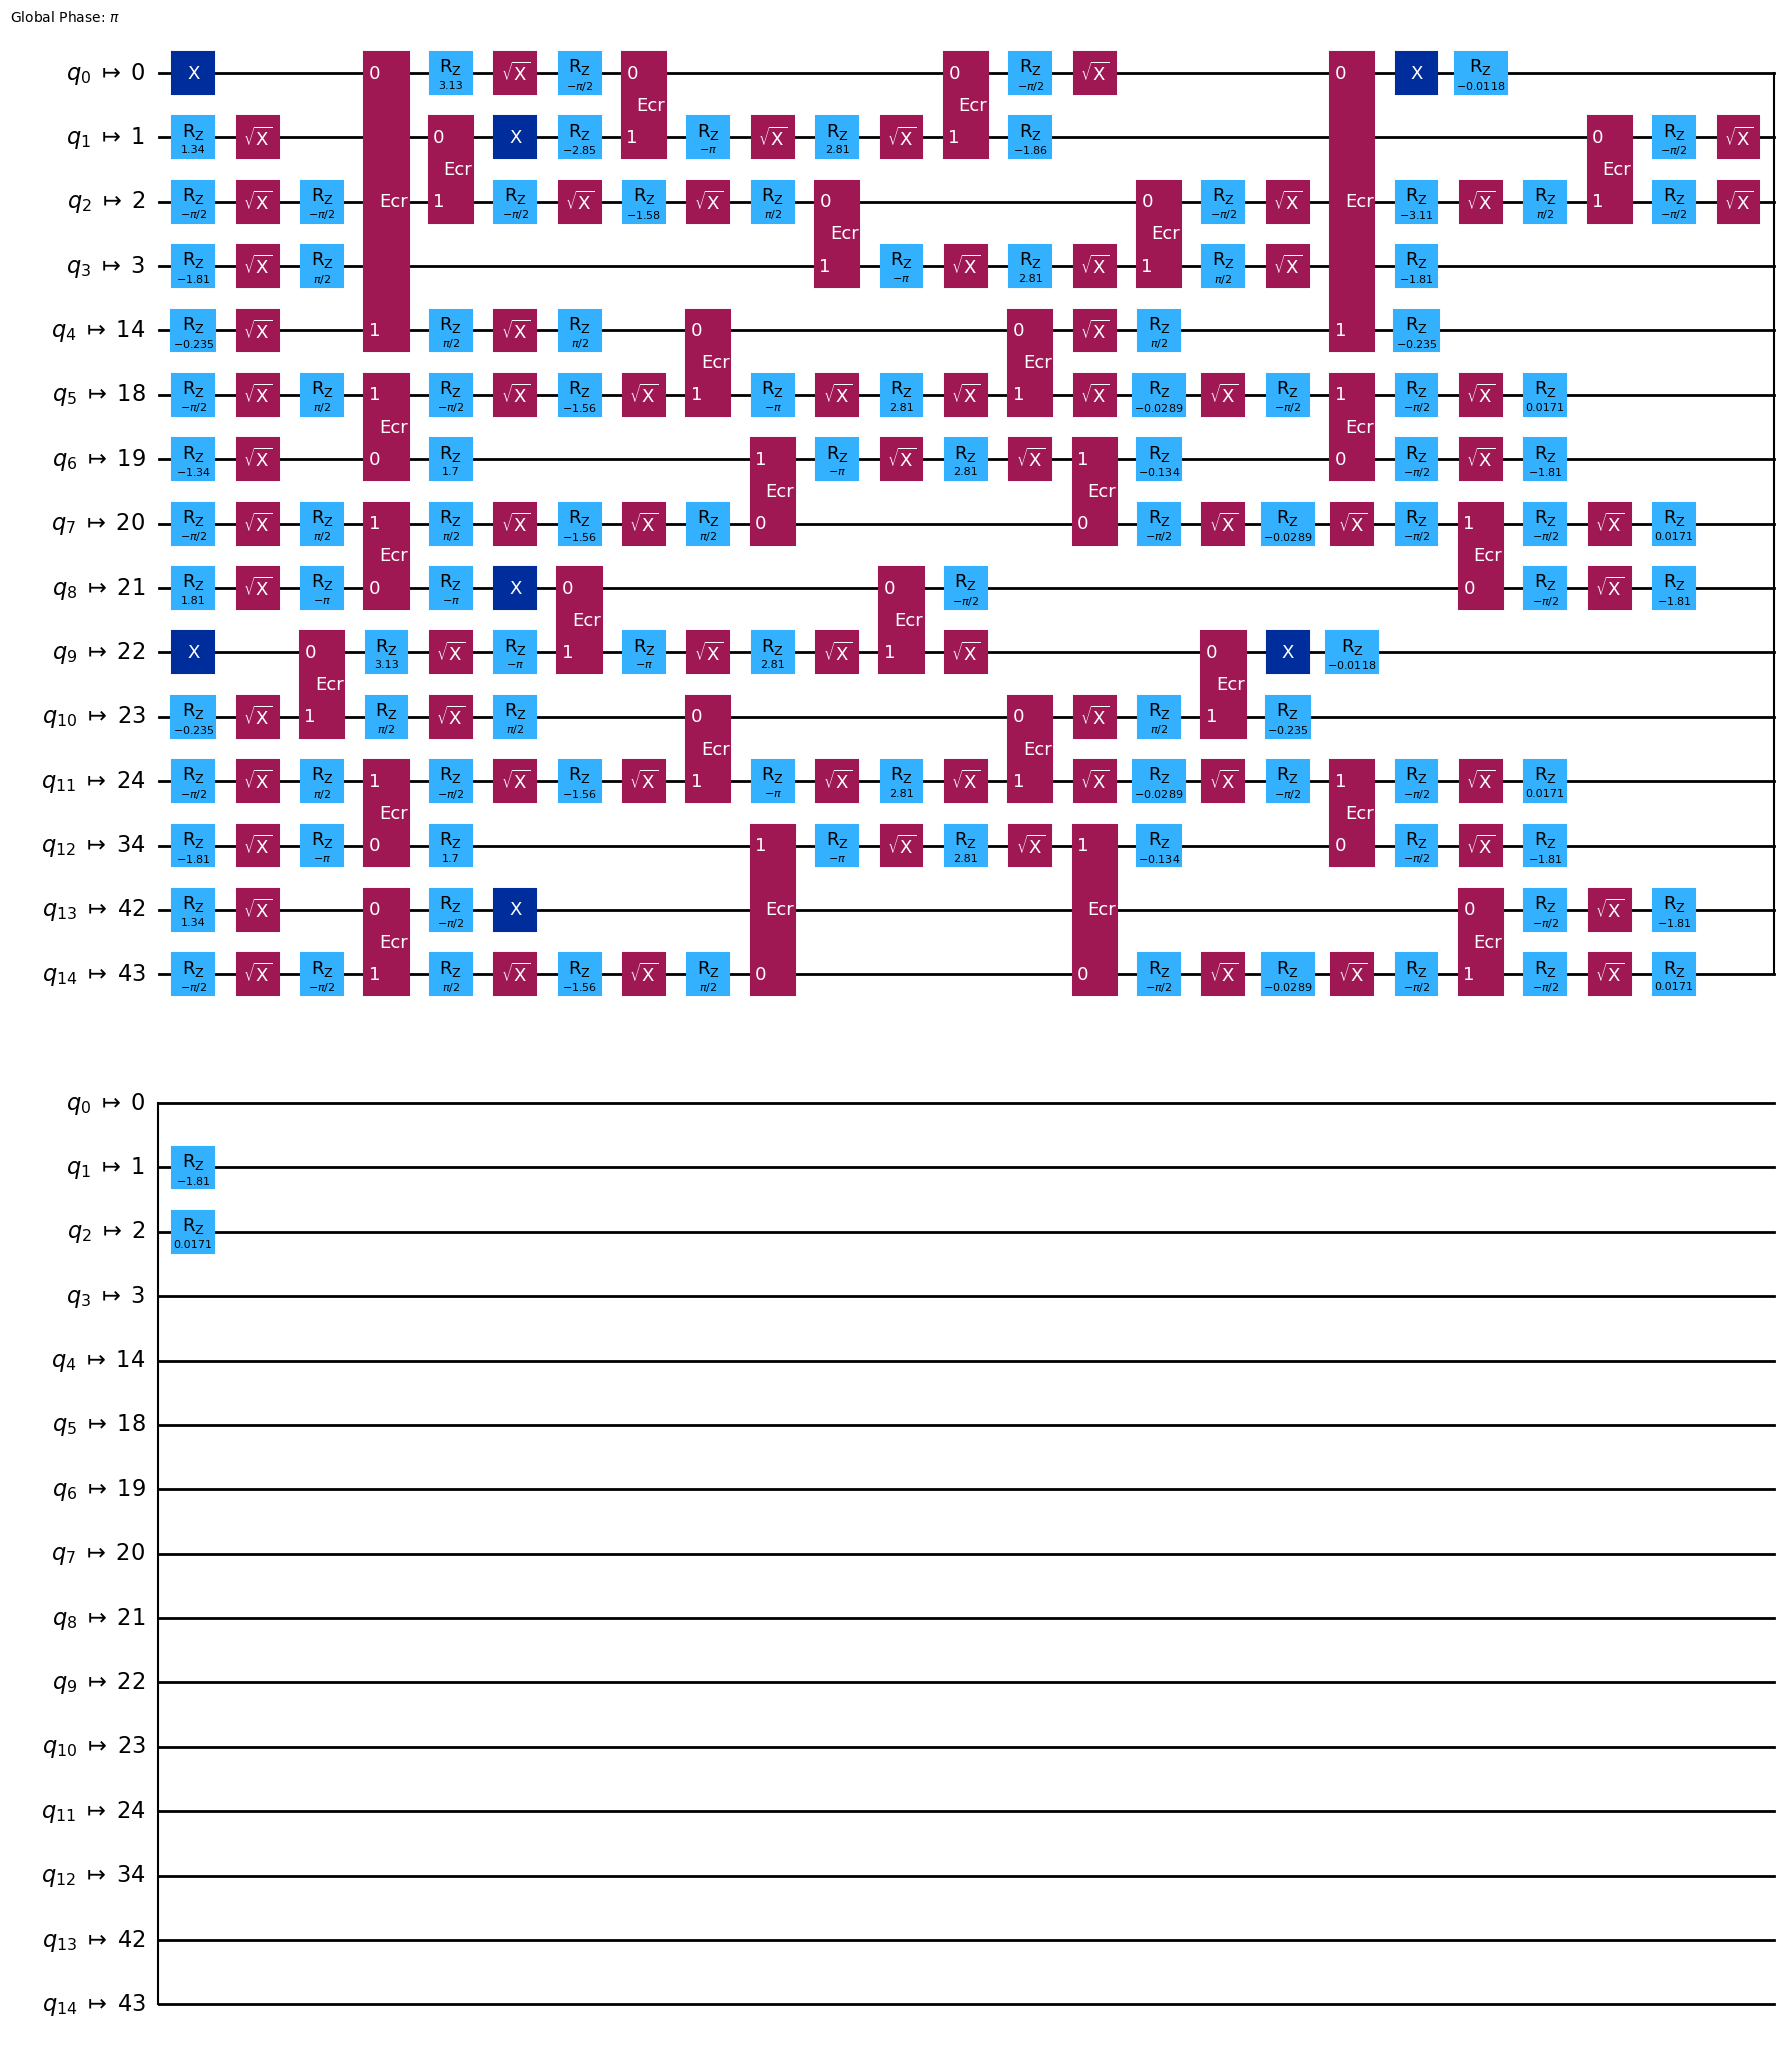

In [4]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits, erradj_particle_pair_quench_simulation_circuits
from z2chain.operators import local_pauli_z, local_pauli_x
from utils.hexec import get_backend_best_qubit_chain
from functools import partial

optimization_level = 2

circuits = [] # circuits[L][t]
observable_generating_funcs = [] #observable_generating_funcs[L][i]

observable_name = "Occupation numbers" + (" X" if x_basis else " Z")

for L, pp_ps in zip(L_arr, particle_pair_left_positions):
    qubits_inds = get_backend_best_qubit_chain(backend, 2*L-1)
    physical_circuits = erradj_particle_pair_quench_simulation_circuits(L, J, h, lamb, pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis)
    observable_generating_funcs.append([partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)])
    circuits.append(physical_circuits)

circuits[0][1].draw(output="mpl", idle_wires=False)

In [5]:
# longest_2qb_depth = physical_circuits[-1].depth(lambda x: len(x.qubits) == 2)
# print(f"Longest circuit has {longest_2qb_depth} 2-qb depth")
# physical_circuits[1].draw(output="mpl", idle_wires=False, fold=-1)

In [6]:
# from qiskit import qpy
# import os

# for i, circuit in enumerate(physical_circuits):
#     filename = f"physical_quench_circuit_layer_{i}_L_{L}_pos_{particle_pair_left_position}_len_{particle_pair_length}.qpy"
#     with open(os.path.join("Circuits", filename), "wb") as f:
#         qpy.dump(circuit, f)

# Estimator circuit execution

### Send jobs to hardware

In [7]:
jobs = [] # jobs[L][opts][i]

for i, L in enumerate(L_arr):
    this_L_jobs = []
    for opts_dict in estimator_options_dict:
        this_jobs = job_db.execute_estimator_batch(backend, opts_dict, circuits[i], observable_generating_funcs[i], observable_name, extra_options=extra_options[i])
        this_L_jobs.append(this_jobs)
    jobs.append(this_L_jobs)

### Load last job with the same options

In [17]:
jobs = []

for L in L_arr:
    this_L_jobs = []
    for opts_dict in estimator_options_dict:
        this_jobs = job_db.search_by_params(opts_dict, physical_circuits, observable_name, strict_depth=False, limit=1, ibmq_service=service)
        this_L_jobs.append(this_L_jobs)
    jobs.append(this_L_jobs)

[<RuntimeJobV2('cv6w3wf4p20g008ryyt0', 'estimator')>,
 <RuntimeJobV2('cv6w3x7kwkwg008t1g8g', 'estimator')>,
 <RuntimeJobV2('cv6w3z7w1n800089dh10', 'estimator')>,
 <RuntimeJobV2('cv6w4104p20g008ryyx0', 'estimator')>,
 <RuntimeJobV2('cv6w42gw1n800089dh20', 'estimator')>,
 <RuntimeJobV2('cv6w44rkwkwg008t1g9g', 'estimator')>,
 <RuntimeJobV2('cv6w4584p20g008ryyxg', 'estimator')>,
 <RuntimeJobV2('cv6w45r4p20g008ryyy0', 'estimator')>,
 <RuntimeJobV2('cv6w46gt5n50008qy9fg', 'estimator')>,
 <RuntimeJobV2('cv6w46rt5n50008qy9g0', 'estimator')>,
 <RuntimeJobV2('cv6w47g4p20g008ryyz0', 'estimator')>,
 <RuntimeJobV2('cv6w491w1n800089dh3g', 'estimator')>,
 <RuntimeJobV2('cv6w4d1mzw700089brz0', 'estimator')>,
 <RuntimeJobV2('cv6w4eskwkwg008t1gb0', 'estimator')>,
 <RuntimeJobV2('cv6w4fht5n50008qy9p0', 'estimator')>,
 <RuntimeJobV2('cv6w4g239kwg008vxpy0', 'estimator')>,
 <RuntimeJobV2('cv6w4gjkwkwg008t1gdg', 'estimator')>,
 <RuntimeJobV2('cv6w4h2mzw700089bs5g', 'estimator')>,
 <RuntimeJobV2('cv6w4hjmzw70

### Load jobs with batch id

In [5]:
session_id = "ctgc5e5q3n6g008fcet0"

jobs = service.jobs(limit=0, session_id=session_id)[::-1]
print(jobs)

[<RuntimeJob('ctgc5edzhysg008rwn3g', 'estimator')>, <RuntimeJob('ctgc5en9fby0008fj3p0', 'estimator')>, <RuntimeJob('ctgc5f5zhysg008rwn4g', 'estimator')>, <RuntimeJob('ctgc5fdr4vc0008a18h0', 'estimator')>, <RuntimeJob('ctgc5fx9fby0008fj3pg', 'estimator')>, <RuntimeJob('ctgc5g6zhysg008rwn50', 'estimator')>, <RuntimeJob('ctgc5geq3n6g008fcev0', 'estimator')>, <RuntimeJob('ctgc5gpq3n6g008fcevg', 'estimator')>, <RuntimeJob('ctgc5gy9fby0008fj3q0', 'estimator')>, <RuntimeJob('ctgc5he9fby0008fj3qg', 'estimator')>, <RuntimeJob('ctgc5hpq3n6g008fcewg', 'estimator')>, <RuntimeJob('ctgc5hyq3n6g008fcex0', 'estimator')>, <RuntimeJob('ctgc5j6bpcr0008rvh8g', 'estimator')>, <RuntimeJob('ctgc5jps6dvg008aza20', 'estimator')>, <RuntimeJob('ctgc5jyzhysg008rwn5g', 'estimator')>, <RuntimeJob('ctgc5ker4vc0008a18hg', 'estimator')>]


# Plots

### Quech plot

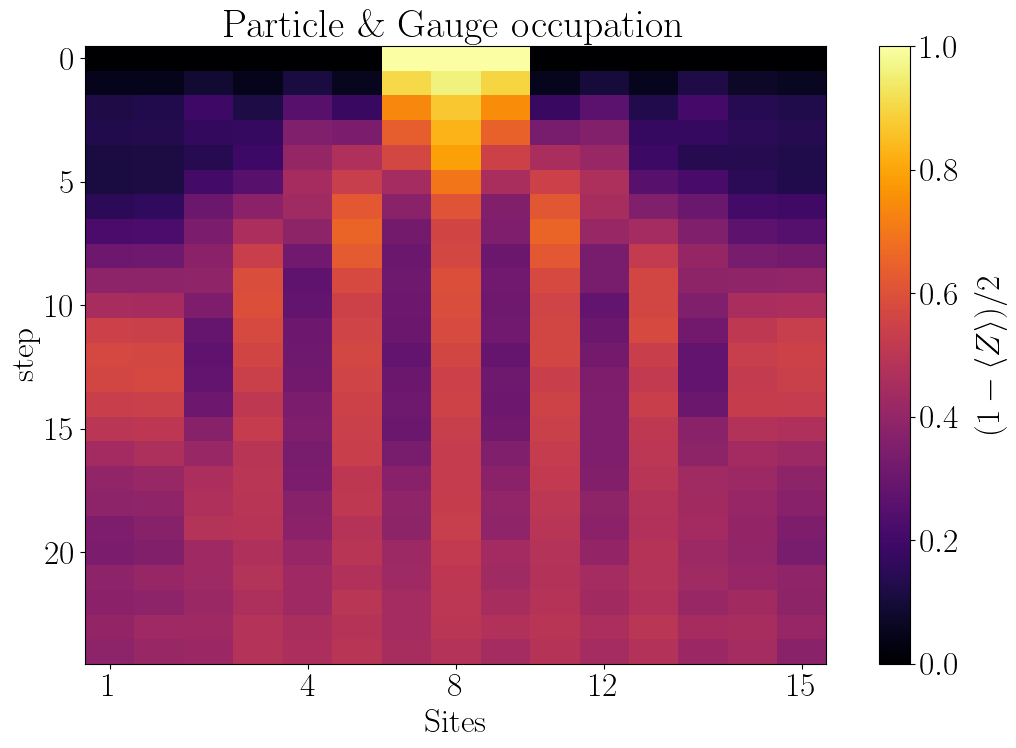

In [8]:
from z2chain.plotting import x_t_plot

for i, L in enumerate(L_arr):
    this_L_jobs = []
    for j, opts_dict in enumerate(estimator_options_dict):
        print(f"L = {L} / Options = {j}")
        x_t_plot(jobs[i][j], filepath=f"Plots/hardware_z2pairquench_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_zne_{opts_dict["resilience"]["zne_mitigation"]}_{opts_dict["resilience"]["zne"]["extrapolator"]}_{"-".join([str(i) for i in opts_dict["resilience"]["zne"]["noise_factors"]])}_mm_{opts_dict["resilience"]["measure_mitigation"]}_dc_{opts_dict["dynamical_decoupling"]["sequence_type"]}_pt_{opts_dict["twirling"]["enable_gates"]}_xbasis_{x_basis}.png")

### Comparison with circuit tensor network simulation

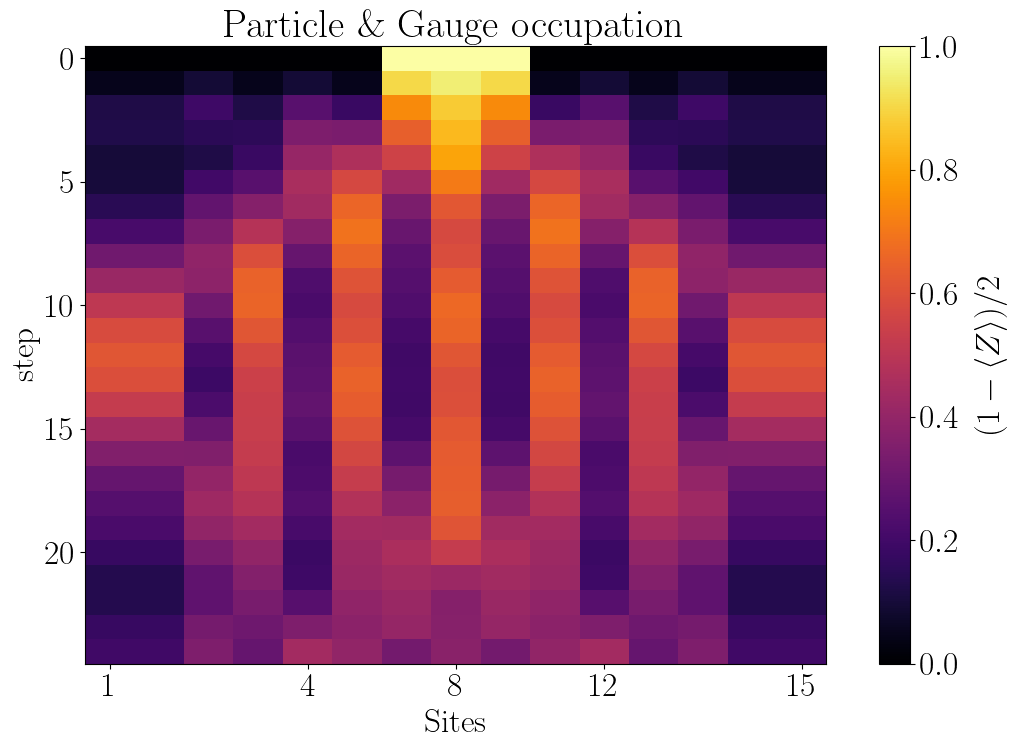

In [9]:
from z2chain.plotting import x_t_plot, save_site_gauge_observable_matrix, load_site_gauge_observable_matrix
from z2chain.circs import particle_pair_quench_simulation_circuits
from utils.sexec import execute_simulation_estimator_batch
import os

simulator_estimator_options = {
    "default_precision": 0
}

mps_simulator_options = {
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-8,
    "max_parallel_threads": 8,
    "max_parallel_experiments": 8
}

filepath = f"Results/tncirc_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_bd_{mps_simulator_options["matrix_product_state_max_bond_dimension"]}_prec_{simulator_estimator_options['default_precision']}.txt"

if os.path.exists(filepath):
    tn_site_gauge_observable_matrix = load_site_gauge_observable_matrix(filepath)
else:
    logical_circs = particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, measure_every_layers)
    observables_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]
    tn_site_gauge_observable_matrix = execute_simulation_estimator_batch(mps_simulator_options, simulator_estimator_options, logical_circs, observables_generating_funcs)
    save_site_gauge_observable_matrix(tn_site_gauge_observable_matrix, filepath)

x_t_plot(tn_site_gauge_observable_matrix, filepath=os.path.join("Plots", os.path.basename(os.path.split(filepath)[1])) + ".png")

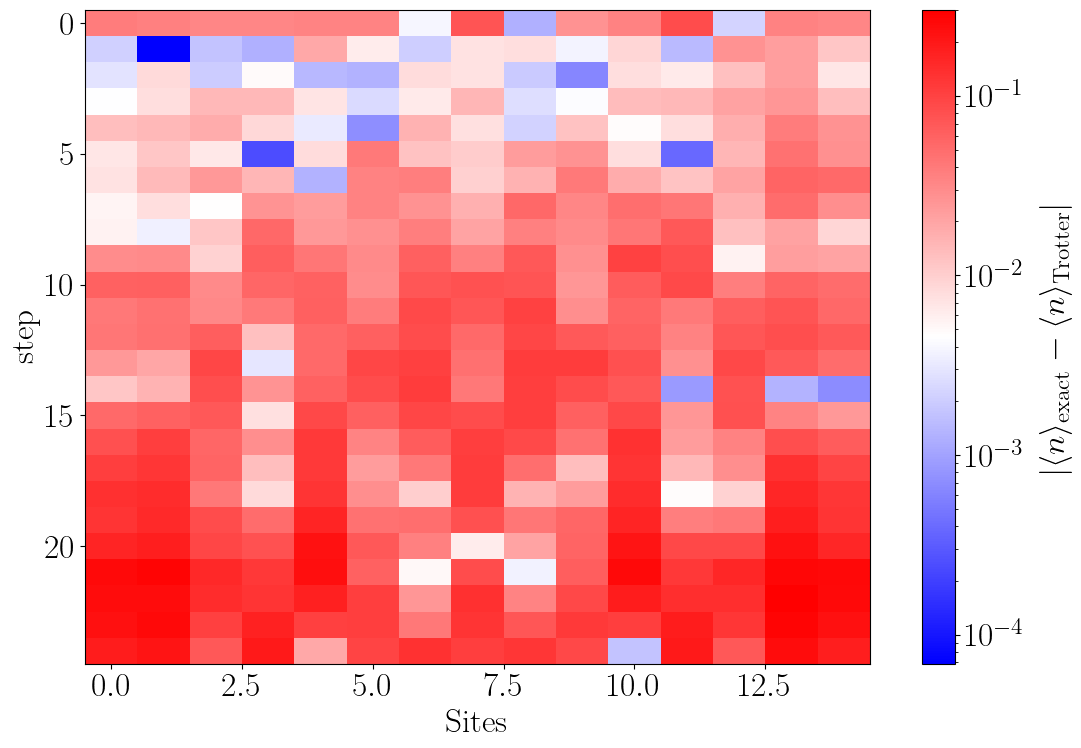

In [14]:
from z2chain.plotting import discrepancies_plot

discrepancies_plot(tn_site_gauge_observable_matrix, jobs, filepath=f"Plots/hardware_discrepancies_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_zne_{estimator_options["resilience"]["zne_mitigation"]}_{"-".join([str(i) for i in estimator_options["resilience"]["zne"]["noise_factors"]])}_mm_{estimator_options["resilience"]["measure_mitigation"]}_dc_{estimator_options["dynamical_decoupling"]["sequence_type"]}_xbasis_{x_basis}.png")